In [14]:
import sys

In [15]:
cd '/srv/flash1/hagrawal9/project/habitat/habitat-api/'

/coc/testnvme/hagrawal9/project/habitat/habitat-api


In [16]:
import pandas as pd

In [17]:
import io
import base64
import imageio
import gzip
import json
import json_tricks
import os
import sys
from typing import Any, Dict, List, Optional, Type

import attr
import cv2
import git
import magnum as mn
import numpy as np

# %matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image

import glob
import habitat
import habitat_sim

from rearrangement.task.sensors import *

from habitat.config import Config
from habitat.core.registry import registry
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.utils import observations_to_image

from habitat_sim.physics import MotionType
from habitat_sim.utils.viz_utils import is_notebook, display_video, get_fast_video_writer

In [18]:
from habitat.datasets.rearrangement.rearrangement_dataset import RearrangementDatasetV0
from habitat.tasks.rearrangement.rearrangement_task import RearrangementEpisode

In [ ]:
os.listdir('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/const_map_object/')
exp_list = [
    'R6dM5HQLwuD2AwkZDwG5Y6', 'TTqk2GgdMfoJHwhxp8anRV', 'K8VC8ciC2rKLPLgF7vhgyr',
    'MuZhjWcSFJdphqKMNUM9gh', 'B5X3WSUod9go46jYd6BTtq', 'HF3DSzaRxdsYWWUwdSPypu',
    'fEvzPSo8M7gxGFr2tqc6pq', 'GmnXbZH9zvtDmWzFRVpgkx', 'o9nPKX24SVJn7Dt5uNqzqy', 'SHK6CZ6SDmpVjRLhVxZBNd'
]

In [ ]:
replay_data = []
files = glob.glob('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/oracle_next_object/Yi8q7gpkU9V385TWwgcZbC/*')
for file in files:
    exp_uuid = file.split('/')[-2]
    # if exp_uuid in exp_list:
    with open(os.path.join(file), 'r') as f:
        data = json_tricks.load(f)
        replay_data.append(data)

In [ ]:
len(replay_data)

In [ ]:
# replay_data = []
# for i, file in enumerate(files[j:]):
#     with open(os.path.join(p, file), 'r') as f:
#         data = json_tricks.load(f)
#         replay_data.append(data)

In [ ]:
replay_df = pd.DataFrame(replay_data)

In [ ]:
replay_df['uid'] = replay_df.apply(lambda x: x['episode_id'] +'_'+ x['scene_id'], axis=1)

In [ ]:
replay_df['episode_spl'] = replay_df.apply(lambda x: x['info']['episode_spl'], axis=1)
replay_df['controller_spl'] = replay_df.apply(lambda x: x['info']['controller_spl'], axis=1)
replay_df['planner_spl'] = replay_df.apply(lambda x: x['info']['planner_spl'], axis=1)
replay_df['episode_success'] = replay_df.apply(lambda x: x['info']['episode_success'], axis=1)
replay_df['objs_success'] = replay_df.apply(lambda x: x['info']['objs_success'], axis=1)
replay_df['episode_length'] = replay_df.apply(lambda x: x['info']['episode_length'], axis=1)
replay_df['episode_mean_dist'] = replay_df.apply(lambda x: x['info']['episode_mean_dist'], axis=1)
replay_df['episode_distance'] = replay_df.apply(lambda x: x['info']['episode_distance'], axis=1)


In [ ]:
replay_df['episode_success'].mean(), replay_df['objs_success'].mean(), replay_df['episode_spl'].mean(), replay_df['planner_spl'].mean(), replay_df['controller_spl'].mean(), replay_df['episode_length'].mean(), replay_df['episode_mean_dist'].mean(), replay_df['episode_distance'].mean()

In [47]:
replay_df.to_pickle('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/oracle_next_object/Yi8q7gpkU9V385TWwgcZbC.pickle')

In [69]:
# del replay_df['actidata/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/l2dist_object/7q3NhKfhy4gW67jNeGdsfA/

In [19]:
randdf = pd.read_pickle('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/random_object/mQgWvVY9k28gdoSUY3cKmG.pickle')
closestdf = pd.read_pickle('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/closest_object/iDyuGZ6SpKrqiychD4uqGM.pickle')
l2df = pd.read_pickle('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/l2dist_object/7q3NhKfhy4gW67jNeGdsfA.pickle')
infmap_df = pd.read_pickle('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/const_map_object/6T4DVDAzwC2ZzkEtGeoerS.pickle')
ormap_df = pd.read_pickle('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/map_object/WWBTQggtmP6xhX6uZRDitE.pickle')
fmap_df = pd.read_pickle('data/new_checkpoints/b9KSrZfBpB5WC5gcCUtmMX/replays/oracle_next_object/Yi8q7gpkU9V385TWwgcZbC.pickle')

In [22]:
randdf['objs_success'].mean(), closestdf['objs_success'].mean(), l2df['objs_success'].mean(), infmap_df['objs_success'].mean(), ormap_df['objs_success'].mean(), fmap_df['objs_success'].mean()

(0.6137999999999999, 0.5954, 0.605, 0.623, 0.6286, 0.6732)

In [23]:
randdf.columns

Index(['episode_id', 'scene_id', 'actions', 'agent_pos',
       'sim_object_id_to_objid_mapping', 'objid_to_sim_object_id_mapping',
       'current_position', 'misc_dict', 'gripped_object_id', 'info', 'uid',
       'episode_spl', 'controller_spl', 'planner_spl', 'episode_success',
       'objs_success', 'episode_length', 'episode_mean_dist',
       'episode_distance'],
      dtype='object')

In [24]:
r = randdf['episode_length'].sem() 
c = closestdf['episode_length'].sem() 
l = l2df['episode_length'].sem() 
i = infmap_df['episode_length'].sem() 
o = ormap_df['episode_length'].sem() 
f = fmap_df['episode_length'].sem() 
print(r, c, l, i, o, f)

6.052670595062343 6.051943732962737 6.647820472608751 6.826674584736399 7.074788193223808 7.323372131701309


In [25]:
rdf = randdf[randdf['episode_spl'] > 0]
cdf = closestdf[closestdf['episode_spl'] > 0]
ldf = l2df[l2df['episode_spl'] > 0]
idf = infmap_df[infmap_df['episode_spl'] > 0]
odf = ormap_df[ormap_df['episode_spl'] > 0]

In [26]:
ruids = rdf['uid'].unique().tolist()
cuids = cdf['uid'].unique().tolist()
luids = ldf['uid'].unique().tolist()
iuids = idf['uid'].unique().tolist()
ouids = odf['uid'].unique().tolist()

In [27]:
common_uids = set(ruids).intersection(cuids).intersection(luids).intersection(iuids).intersection(ouids)

In [28]:

for uid in common_uids:
    rrow = randdf[randdf['uid']==uid].iloc[0]
    crow = closestdf[closestdf['uid']==uid].iloc[0]
    lrow = l2df[l2df['uid']==uid].iloc[0]
    irow = infmap_df[infmap_df['uid']==uid].iloc[0]
    orow = ormap_df[ormap_df['uid']==uid].iloc[0]
    # print(rrow['uid'], crow['uid'], lrow['uid'], irow['uid'], orow['uid'])
    if crow['episode_spl'] < lrow['episode_spl'] < irow['episode_spl']:
        print(uid)
        print(crow['episode_spl'], lrow['episode_spl'], irow['episode_spl'])
        print(crow['planner_spl'], lrow['planner_spl'], irow['planner_spl'])
        print('--')

38_data/scene_datasets/gibson_train_val/Sands.glb
0.6702293636785678 0.8074221027946996 0.824320912287596
0.7021480851448192 0.8568082975823397 0.8683408344002339
--
52_data/scene_datasets/gibson_train_val/Southfield.glb
0.7414641373511199 0.7612385388517792 0.8820924176103347
0.8654898758898728 0.8731991180316114 0.9794941277297651
--
25_data/scene_datasets/gibson_train_val/Sands.glb
0.6044257654478953 0.7610624355952644 0.7812833454691945
0.7233298369097172 0.9107788781415084 0.9559446119981732
--
63_data/scene_datasets/gibson_train_val/Sands.glb
0.7324563208904551 0.8627042523352068 0.9282027203452259
0.7651681184291991 0.8969298795140958 0.979968215271435
--
75_data/scene_datasets/gibson_train_val/Silerton.glb
0.6233862833135576 0.6762865883033872 0.8180250421424031
0.7583508421732855 0.9255706126894269 1.0
--
58_data/scene_datasets/gibson_train_val/Sands.glb
0.6407231013193727 0.7406514855452088 0.8177808172150036
0.7302268404233703 0.8761438847835636 0.8439808685540358
--
13_data

In [29]:
eplist = ['27_data/scene_datasets/gibson_train_val/Sagerton.glb',
'8_data/scene_datasets/gibson_train_val/Cokeville.glb',
'5_data/scene_datasets/gibson_train_val/Sands.glb',
'32_data/scene_datasets/gibson_train_val/Sands.glb',
'75_data/scene_datasets/gibson_train_val/Silerton.glb',
'13_data/scene_datasets/gibson_train_val/Southfield.glb',
'52_data/scene_datasets/gibson_train_val/Southfield.glb',
'71_data/scene_datasets/gibson_train_val/Sands.glb',
'6_data/scene_datasets/gibson_train_val/Silerton.glb',
'93_data/scene_datasets/gibson_train_val/Silerton.glb',
'61_data/scene_datasets/gibson_train_val/Wells.glb']

In [30]:
for uid in eplist:
    rrow = randdf[randdf['uid']==uid].iloc[0]
    crow = closestdf[closestdf['uid']==uid].iloc[0]
    lrow = l2df[l2df['uid']==uid].iloc[0]
    irow = infmap_df[infmap_df['uid']==uid].iloc[0]
    orow = ormap_df[ormap_df['uid']==uid].iloc[0]

    print(uid)
    print(crow['episode_spl'], lrow['episode_spl'], irow['episode_spl'])
    print(crow['planner_spl'], lrow['planner_spl'], irow['planner_spl'])
    print('--')

27_data/scene_datasets/gibson_train_val/Sagerton.glb
0.6090886827456136 0.7425190899684763 0.9763519433581209
0.8472915452114503 0.871067167061915 0.9917092796684661
--
8_data/scene_datasets/gibson_train_val/Cokeville.glb
0.4218093645260496 0.6347181967512453 0.7169992610611482
0.8650634437662169 0.8893954754600716 0.9471501655208101
--
5_data/scene_datasets/gibson_train_val/Sands.glb
0.6425193319358604 0.8051001615185316 0.920432627930588
0.6711082354982533 0.8612049202004367 0.983147944554456
--
32_data/scene_datasets/gibson_train_val/Sands.glb
0.650517482020078 0.8260284833229199 0.9814255704175291
0.6558146050668586 0.8712146956499146 1.0
--
75_data/scene_datasets/gibson_train_val/Silerton.glb
0.6233862833135576 0.6762865883033872 0.8180250421424031
0.7583508421732855 0.9255706126894269 1.0
--
13_data/scene_datasets/gibson_train_val/Southfield.glb
0.641579693726637 0.7051740294282065 0.8904759252756232
0.7302360077045269 0.7863036744049767 1.0
--
52_data/scene_datasets/gibson_train

In [31]:
def depth_to_rgb(depth_image: np.ndarray, clip_max: float = 10.0) -> np.ndarray:
    """Normalize depth image into [0, 1] and convert to grayscale rgb
    :param depth_image: Raw depth observation image from sensor output.
    :param clip_max: Max depth distance for clipping and normalization.
    :return: Clipped grayscale depth image data.
    """
    d_im = np.clip(depth_image, 0, clip_max)
    d_im /= clip_max
    # d_im = np.stack([d_im for _ in range(3)], axis=2)
    rgb_d_im = (d_im * 255).astype(np.uint8)
    return rgb_d_im

In [32]:
def render_frame(obs, info):
    img_frame = Image.fromarray(obs['rgb_3rd_person'])
    rgb = Image.fromarray(obs['rgb'])
    
    if "depth" in obs:
        d_im = depth_to_rgb(obs['depth'], clip_max=1.0)[:, :, 0]
        depth_map = np.stack([d_im for _ in range(3)], axis=2)

        depth = Image.fromarray(
            depth_map
        )


    overlay_rgb_img = rgb.resize((64, 64))
    overlay_depth_img = depth.resize((64, 64))

    img_frame.paste(overlay_rgb_img, box=(32, 32))
    img_frame.paste(overlay_depth_img, box=(32, 100))
    img_frame = np.array(img_frame)
    
    top_down_map = maps.colorize_draw_agent_and_fit_to_height(
            info["top_down_map"], img_frame.shape[0]
        )
    img_frame = np.concatenate((img_frame, top_down_map), axis=1)
    return img_frame, top_down_map

In [33]:
def render_video_and_save_data(eplist, i, df, dftype):
    uid = eplist[i]
    eid = eplist[i].split('_')[0]
    scene_id = eplist[i][len(eid) + 1:]
    print(eid, scene_id)
    
    data = df[df['uid'] == uid].iloc[0].to_dict()
    
    config = habitat.get_config("configs/tasks/rearrangement_gibson_map.yaml")
    
    config.defrost()
    config.DATASET.SPLIT = "test"
    config.DATASET.CONTENT_SCENES = [f"rearrangement_hard_v8_{config.DATASET.SPLIT}_n=100_o=5_t=0.9_{scene_id.split('/')[-1].split('.')[0]}"]
    config.TASK.MEASUREMENTS = ['OBJECT_TO_GOAL_DISTANCE', 'AGENT_TO_OBJECT_DISTANCE', 'EOR_TOP_DOWN_MAP']
    config.TASK.SENSORS = ['GRIPPED_OBJECT_SENSOR', 'ALL_OBJECT_POSITIONS', 'ALL_OBJECT_GOALS', 'ORACLE_NEXT_OBJECT_SENSOR',]
    # config.defrost()
    config.SIMULATOR.DEPTH_SENSOR.HEIGHT = 1024
    config.SIMULATOR.DEPTH_SENSOR.WIDTH = 1024
    config.SIMULATOR.RGB_SENSOR.HEIGHT = 1024
    config.SIMULATOR.RGB_SENSOR.WIDTH = 1024
    config.SIMULATOR.CROSSHAIR_POS = [512, 768]
    config.SIMULATOR.RGB_SENSOR_3RD_PERSON.HEIGHT = 1024
    config.SIMULATOR.RGB_SENSOR_3RD_PERSON.WIDTH = 1820
    config.TASK.EOR_TOP_DOWN_MAP.MAX_RESOLUTION = 1024
    config.TASK.EOR_TOP_DOWN_MAP.MAX_RESOLUTION = 1024
    # config.freeze()
    config.freeze()
    
    try:
        env.close()
    except:
        pass
    env = habitat.Env(config)
    
    # go to the desired episode
    for ep in env.episodes:
        if ep.episode_id == eid:
            break
    
    env._current_episode = ep
    env._reset_stats()

    if env._current_episode is not None:
        env._current_episode._shortest_path_cache = None
    env.reconfigure(env._config)
    obs = env.task.reset(episode=env.current_episode)
    env._task.measurements.reset_measures(
        episode=env.current_episode, task=env.task
    )
    metrics = env.get_metrics()
    
    plt.imshow(obs['rgb_3rd_person'])
    plt.show()
    
    top_down_map = maps.get_topdown_map(
        env._task._simple_pathfinder,
        env._sim.get_agent(0).state.position[1],
        1024
    )

    top_down_map = maps.colorize_topdown_map(top_down_map)
    agent_position = env._sim.get_agent_state().position
    a_x, a_y = maps.to_grid(
        agent_position[2],
        agent_position[0],
        top_down_map.shape[0:2],
        sim=env._sim,
    )

    episode = env.current_episode
    object_positions = [obj.position for obj in episode.objects]
    goal_positions = [obj.position for obj in episode.goals]

    grid_object_positions = []
    grid_goal_positions = []

    for i, obj_pos in enumerate(object_positions):
        tdm_pos = maps.to_grid(
            obj_pos[2],
            obj_pos[0],
            top_down_map.shape[0:2],
            sim=env._sim,
        )
        grid_object_positions.append(tdm_pos)

    # draw the objectgoal positions.
    for i, goal_pos in enumerate(goal_positions):
        tdm_pos = maps.to_grid(
            goal_pos[2],
            goal_pos[0],
            top_down_map.shape[0:2],
            sim=env._sim,
        )

        grid_goal_positions.append(tdm_pos)

    grid_current_positions = [None] * len(object_positions)
    for sim_obj_id in env._sim.get_existing_object_ids():
        if sim_obj_id != env._task.agent_object_id:
            obj_id = env._task.sim_object_to_objid_mapping[sim_obj_id]
            position = env._sim.get_translation(sim_obj_id)
            curr_pos = maps.to_grid(position[2], position[0], top_down_map.shape[0:2], sim=env._sim)
            grid_current_positions[obj_id] = curr_pos


    top_down_map = maps.draw_agent(
        image=top_down_map,
        agent_center_coord=[a_x, a_y],
        agent_rotation=0,
        agent_radius_px=min(top_down_map.shape[0:2]) / 32,
    )

    top_down_map = maps.draw_object_info(top_down_map, grid_goal_positions, suffix='g')
    top_down_map = maps.draw_object_info(top_down_map, grid_current_positions, suffix='c')

    plt.imshow(top_down_map)
    plt.show()
    
    frames = []
    metric_list = []
    obs_list = []
    constructed_map = []
    top_down_map_frames = []

    for action in data['actions']:
        obs = env.step(action['action'])
        metrics = env.get_metrics()
        print(metrics['top_down_map']['map'].shape)
        # info = env.get_info(obs)
        img_frame, top_down_map = render_frame(obs, metrics)
        frames.append(img_frame)
        top_down_map_frames.append(top_down_map)
        obs_list.append(obs)
        # constructed_map.append(env._task.misc_dict['obstacles_mask'])
        metric_list.append(metrics)

        print(f"\r {len(frames)}, {len(data['actions'])}", end=" ")

    #     plt.imshow(obs['rgb_3rd_person'])
    #     plt.title(action)
    #     plt.show()
    env.close()
    name = eid + '_' + scene_id.split('/')[-1].split('.')[0] + '_' + dftype + '.mp4'
    
    
    result_data = {
        'name': eid + '_' + scene_id.split('/')[-1].split('.')[0] + '_' + dftype,
        'frames': frames, 
        'metric_list': metric_list, 
        'obs_list': obs_list, 
        'top_down_map_frames': top_down_map_frames
    }
    
    
    map_name = eid + '_' + scene_id.split('/')[-1].split('.')[0]
    dir_path = os.path.join('data/map_visualizations/', dftype, map_name)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    
    for i, tdmframe in enumerate(top_down_map_frames):
        im = Image.fromarray(tdmframe)
        im.save(dir_path + '/' + str(i) + '.png')
    # writer = get_fast_video_writer('data/' + name, fps=10)
    
    
#     for image_frame in frames:
#         writer.append_data(np.array(image_frame))
#     #    plt.figure(figsize=(5,10), dpi=300)
#     #     plt.imshow()
#     #     plt.savefig(name[:-4] + '.jpg'

    # writer.close()
    
    print(name)
    
    
    
    return result_data

In [ ]:
result_data = render_video_and_save_data(eplist, 2, l2df, 'l2df')

2020-11-16 22:10:55,611 Initializing dataset RearrangementDataset-v0
2020-11-16 22:10:55,635 initializing sim RearrangementSim-v0


5 data/scene_datasets/gibson_train_val/Sands.glb
Episode Length: 0
Episode Length: 100


I1116 22:11:01.129416 21994 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Sands.navmesh
I1116 22:11:01.132111 21994 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.
2020-11-16 22:11:01,312 Initializing task RearrangementTask-v0


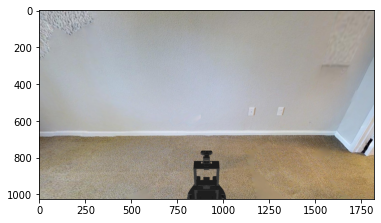

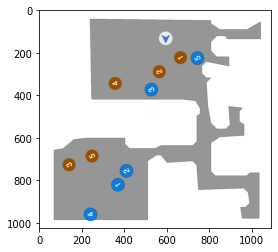

(1024, 1091)
 1, 340 (1024, 1091)
 2, 340 (1024, 1091)
 3, 340 (1024, 1091)
 4, 340 (1024, 1091)
 5, 340 (1024, 1091)
 6, 340 (1024, 1091)
 7, 340 (1024, 1091)
 8, 340 (1024, 1091)
 9, 340 (1024, 1091)
 10, 340 (1024, 1091)
 11, 340 (1024, 1091)
 12, 340 (1024, 1091)
 13, 340 (1024, 1091)
 14, 340 (1024, 1091)
 15, 340 (1024, 1091)
 16, 340 (1024, 1091)
 17, 340 (1024, 1091)
 18, 340 (1024, 1091)
 19, 340 (1024, 1091)
 20, 340 (1024, 1091)
 21, 340 (1024, 1091)
 22, 340 (1024, 1091)
 23, 340 (1024, 1091)
 24, 340 (1024, 1091)
 25, 340 (1024, 1091)
 26, 340 (1024, 1091)
 27, 340 (1024, 1091)
 28, 340 (1024, 1091)
 29, 340 (1024, 1091)
 30, 340 (1024, 1091)
 31, 340 (1024, 1091)
 32, 340 (1024, 1091)
 33, 340 (1024, 1091)
 34, 340 (1024, 1091)
 35, 340 (1024, 1091)
 36, 340 (1024, 1091)
 37, 340 (1024, 1091)
 38, 340 (1024, 1091)
 39, 340 (1024, 1091)
 40, 340 (1024, 1091)
 41, 340 (1024, 1091)
 42, 340 (1024, 1091)
 43, 340 (1024, 1091)
 44, 340 (1024, 1091)
 45, 340 (1024, 1091)
 46, 3

In [35]:
result_data = render_video_and_save_data(eplist, 2, infmap_df, 'inf')

2020-11-16 18:21:15,979 Initializing dataset RearrangementDataset-v0
2020-11-16 18:21:16,000 initializing sim RearrangementSim-v0


27 data/scene_datasets/gibson_train_val/Sagerton.glb
Episode Length: 0
Episode Length: 100


I1116 18:21:20.445076 40914 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Sagerton.navmesh
I1116 18:21:20.446774 40914 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.
2020-11-16 18:21:20,705 Initializing task RearrangementTask-v0


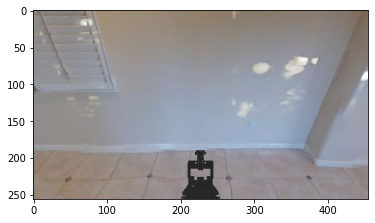

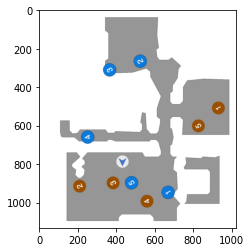

 540, 541 

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (738, 256) to (752, 256) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


 541, 541 

2020-11-16 18:22:43,886 Initializing dataset RearrangementDataset-v0
2020-11-16 18:22:43,906 initializing sim RearrangementSim-v0


27_Sagerton_rand.mp4
27 data/scene_datasets/gibson_train_val/Sagerton.glb
Episode Length: 0
Episode Length: 100


I1116 18:22:48.087680 40914 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Sagerton.navmesh
I1116 18:22:48.090393 40914 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.
2020-11-16 18:22:48,340 Initializing task RearrangementTask-v0


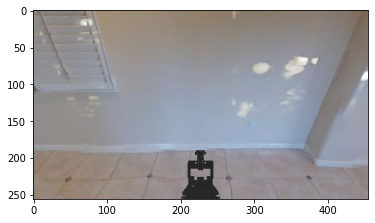

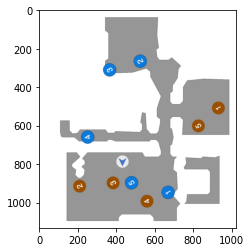

 571, 612 

In [ ]:
for i in range(len(eplist)):
    # result_data = render_video_and_save_data(eplist, i, randdf, 'rand')
    result_data = render_video_and_save_data(eplist, i, l2df, 'l2')
    # result_data = render_video_and_save_data(eplist, i, closestdf, 'closest')
    result_data = render_video_and_save_data(eplist, i, infmap_df, 'infmap')
    
    uid = eplist[i]
    
    rrow = randdf[randdf['uid']==uid].iloc[0]
    crow = closestdf[closestdf['uid']==uid].iloc[0]
    lrow = l2df[l2df['uid']==uid].iloc[0]
    irow = infmap_df[infmap_df['uid']==uid].iloc[0]
    orow = ormap_df[ormap_df['uid']==uid].iloc[0]

    print(uid)
    print(crow['episode_spl'], lrow['episode_spl'], irow['episode_spl'])
    print(crow['planner_spl'], lrow['planner_spl'], irow['planner_spl'])
    print('--')

In [21]:
display_video('data/5_Sands_rand.mp4')

In [105]:
def restore_state(replay, env):
    for sim_obj_id, obj_id in replay['sim_object_id_to_objid_mapping'].items(): 
        curr_sim_obj_id = env._task.objid_to_sim_object_mapping[obj_id]
        env._sim.set_object_motion_type(
            MotionType.KINEMATIC, curr_sim_obj_id
        )
        env._sim.set_translation(replay['current_position'][sim_obj_id], curr_sim_obj_id)
        env._sim.set_object_motion_type(
            MotionType.STATIC, curr_sim_obj_id
        )
        agent_cfg = env._sim._get_agent_config(0)
        env._sim.set_agent_state(
            replay['agent_pos'],
            agent_cfg.START_ROTATION,
            0,
        )
        env._sim.set_translation(replay['agent_pos'], env._task.agent_object_id)
        

        print(sim_obj_id, obj_id, curr_sim_obj_id)
    env._task.measurements.update_measures(
        episode=env.current_episode, action=0, task=env.task
    )

In [106]:
# for obj_id, goal in enumerate(env.current_episode.goals):

#     agent_state = env._sim.get_agent_state()
#     agent_position = agent_state.position
#     sim_obj_id = env._task.objid_to_sim_object_mapping[obj_id]
#     previous_position = np.array(
#         env._sim.get_translation(sim_obj_id)
#     ).tolist()

#     goal_position = env.current_episode.goals[obj_id].position
#     previous_position[1] = agent_position[1]
 
#     d = geodesic_distance(
#         env._sim.pathfinder, previous_position, agent_position
#     )
#     print(obj_id, d)

In [111]:
result_data = {
    'frames': frames, 
    'metric_list': metric_list, 
    'obs_list': obs_list, 
}

In [112]:
with open('data/'+ name + '.json', 'w') as f:
    json_tricks.dump(result_data, f)

KeyboardInterrupt: 